In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
deaths_age = pd.read_csv('BE0101D8_20201216-204712.csv').set_index('age')

In [3]:
deaths_age.head()

,2014,2015,2016,2017,2018,2019
age,,,,,,
0-4 years,299,333,344,322,302,289
5-9 years,44,41,54,40,34,36
10-14 years,32,51,41,44,51,36
15-19 years,113,109,102,124,133,122
20-24 years,288,290,229,251,272,246


In [4]:
pop_age = pd.read_csv('BE0101C£_20201216-232934.csv')
pop_age = pop_age.drop(columns='age')

pop_age_agg = pd.concat([pop_age.iloc[0:65].sum(), pop_age.iloc[65:80].sum(),  pop_age.iloc[80:90].sum(), pop_age.iloc[90:].sum()], axis=1)
pop_age_agg = pop_age_agg.rename(columns={0:'0-64',1:'65-79', 2:'80-89', 3:'90+'})
pop_age_agg.loc['2020'] = np.nan
pop_age_agg = pop_age_agg.shift()
pop_age_agg['total'] = pop_age_agg.sum(axis=1)
pop_age_agg.tail()

,0-64,65-79,80-89,90+,total
2016,7903790.0,1445577.0,405287.0,96363.0,9851017.0
2017,8018296.0,1469963.0,409775.0,97119.0,9995153.0
2018,8114096.0,1493476.0,415286.0,97384.0,10120242.0
2019,8194474.0,1513578.0,423830.0,98303.0,10230185.0
2020,8262222.0,1529061.0,436679.0,99627.0,10327589.0


In [5]:
deaths_age = pd.read_csv('BE0101D8_20201217-174639.csv')
deaths_age = deaths_age.drop(columns='age')
deaths_age_agg = pd.concat([deaths_age.iloc[0:65].sum(), deaths_age.iloc[65:80].sum(),  deaths_age.iloc[80:90].sum(), deaths_age.iloc[90:].sum()], axis=1)
deaths_age_agg = deaths_age_agg.rename(columns={0:'0-64',1:'65-79', 2:'80-89', 3:'90+'})

####
deaths_2020 = pd.read_excel('2020-12-21-preliminar_statistik_over_doda_inkl_eng.xlsx', sheet_name = 'Tabell 2', skiprows = range(0,6), engine='openpyxl')

deaths_2020['0-64'] = deaths_2020['0-64 år.2'] + deaths_2020['0-64 år.3']
deaths_2020['65-79'] = deaths_2020['65-79 år.2'] + deaths_2020['65-79 år.3']
deaths_2020['80-89'] = deaths_2020['80-89 år.2'] + deaths_2020['80-89 år.3']
deaths_2020['90+'] = deaths_2020['90+ år.2'] + deaths_2020['90+ år.3']

#estimate december 2020 deaths
deaths_2020 = deaths_2020.drop(0)
december_values = deaths_2020.set_index('Unnamed: 22').loc['december'][['0-64', '65-79', '80-89', '90+']].iloc[0:7].mean().astype(int)
deaths_2020 = deaths_2020.groupby('Unnamed: 22')[['0-64', '65-79', '80-89', '90+']].sum()
deaths_2020.loc['december'] = december_values*31

###
deaths_age_agg.loc['2020'] = deaths_2020.sum()
deaths_age_agg['total'] = deaths_age_agg.sum(axis=1)
deaths_age_agg.tail()

,0-64,65-79,80-89,90+,total
2016,10410,25474,30791,24307,90982
2017,10260,25601,31333,24778,91972
2018,10172,26233,31238,24542,92185
2019,9757,25393,30220,23396,88766
2020,9295,27183,33921,23983,94382


In [6]:
deaths_2020.sum(axis=1)

Unnamed: 22
april        10375
augusti       6788
december      9207
februari      7366
januari       7868
juli          6850
juni          7238
maj           8706
mars          8371
november      7974
oktober       7053
september     6586
dtype: int64

In [7]:
deaths_age_adj = (deaths_age_agg/pop_age_agg)*pop_age_agg.loc['2019']
deaths_age_adj['total'] = deaths_age_adj['0-64'] + deaths_age_adj['65-79'] + deaths_age_adj['80-89'] + deaths_age_adj['90+']

In [8]:
deaths_age_adj['total/million'] = deaths_age_adj['total']/(pop_age_agg['total'].loc['2019']/1000000)
deaths_age_adj['0-64/million'] = deaths_age_adj['0-64']/(pop_age_agg['0-64'].loc['2019']/1000000)
deaths_age_adj['65-79/million'] = deaths_age_adj['65-79']/(pop_age_agg['65-79'].loc['2019']/1000000)
deaths_age_adj['80-89/million'] = deaths_age_adj['80-89']/(pop_age_agg['80-89'].loc['2019']/1000000)
deaths_age_adj['90+/million'] = deaths_age_adj['90+']/(pop_age_agg['90+'].loc['2019']/1000000)

deaths_age_adj.tail()

,0-64,65-79,80-89,90+,total,total/million,0-64/million,65-79/million,80-89/million,90+/million
2016,10792.856888,26672.315603,32199.773321,24796.353590,94461.299402,9233.586626,1317.089649,17622.029127,75973.322608,252244.118593
2017,10485.432720,26360.602531,32407.700299,25080.074280,94333.809830,9221.124528,1279.573615,17416.084623,76463.913123,255130.304060
2018,10272.763537,26586.092896,31880.683529,24773.599626,93513.139589,9140.904059,1253.620859,17565.062981,75220.450485,252012.650949
2019,9757.000000,25393.000000,30220.000000,23396.000000,88766.000000,8676.871435,1190.680451,16776.803045,71302.173041,237998.840320
2020,9218.783498,26907.749772,32922.896292,23664.276240,92713.705802,9062.759452,1125.000030,17777.577219,77679.485389,240727.915123


In [9]:
window1 = 5
window2 = 3
deaths_age_adj['5 year trendline'] = deaths_age_adj['total/million'].shift().rolling(window = window1).apply(lambda x: np.polyval(np.polyfit(np.array(range(0,window1)), x, 1), window1), raw=True)
deaths_age_adj['3 year mean'] = deaths_age_adj['total/million'].rolling(window2).mean().shift()

deaths_age_adj['excess1'] = deaths_age_adj['total/million'] - deaths_age_adj['5 year trendline']
deaths_age_adj['excess2'] = deaths_age_adj['total/million'] - deaths_age_adj['3 year mean']



In [10]:
deaths_age_adj.sort_values(by = 'excess1', ascending=False).iloc[0:10]

,0-64,65-79,80-89,90+,total,total/million,0-64/million,65-79/million,80-89/million,90+/million,5 year trendline,3 year mean,excess1,excess2
1985,18983.019142,49673.185001,48948.024758,30148.180783,147752.409684,14442.789616,2316.563472,32818.384650,115489.759474,306686.273896,13773.316973,14364.835147,669.472642,77.954469
1993,15754.737664,43287.185858,45181.790294,29620.093569,133843.807384,13083.224534,1922.605119,28599.243552,106603.568162,301314.238309,12671.482591,13162.838863,411.741943,-79.614329
2020,9218.783498,26907.749772,32922.896292,23664.276240,92713.705802,9062.759452,1125.000030,17777.577219,77679.485389,240727.915123,8698.628115,9012.966674,364.131336,49.792778
1988,18312.757192,47043.751848,48394.635233,30063.643358,143814.787631,14057.887285,2234.769089,31081.154621,114184.071993,305826.305991,13746.800327,14081.742281,311.086957,-23.854996
1976,22753.211779,55234.700654,55915.605583,32854.447907,166757.965924,16300.581654,2776.653118,36492.800936,131929.324454,334216.126744,16015.791633,16197.548287,284.790021,103.033367
2007,13499.663214,31928.226891,36696.220394,26528.559374,108652.669874,10620.792280,1647.410586,21094.536847,86582.404252,269865.206291,10347.889251,10774.751157,272.903030,-153.958877
1980,21427.142542,51855.434232,52401.978287,30639.444099,156323.999161,15280.661998,2614.828303,34260.166462,123639.143731,311683.713611,15012.212592,15414.923619,268.449406,-134.261621
1990,17078.893686,44752.247769,45977.302086,29013.168126,136821.611667,13374.304733,2084.196458,29567.189645,108480.527772,295140.210633,13155.005367,13671.673126,219.299366,-297.368393
2015,10987.716895,26826.176077,32768.297207,24921.377205,95503.567384,9335.468262,1340.869090,17723.682609,77314.718653,253515.937513,9126.327914,9534.855356,209.140348,-199.387093
1996,14539.415690,40350.260267,42301.421530,27950.467219,125141.564706,12232.580809,1774.295176,26658.857533,99807.520774,284329.748014,12028.717177,12547.096493,203.863632,-314.515684


In [11]:
deaths_age_adj.sort_values(by = 'excess2', ascending=False).iloc[0:10]

,0-64,65-79,80-89,90+,total,total/million,0-64/million,65-79/million,80-89/million,90+/million,5 year trendline,3 year mean,excess1,excess2
1976,22753.211779,55234.700654,55915.605583,32854.447907,166757.965924,16300.581654,2776.653118,36492.800936,131929.324454,334216.126744,16015.791633,16197.548287,284.790021,103.033367
1985,18983.019142,49673.185001,48948.024758,30148.180783,147752.409684,14442.789616,2316.563472,32818.384650,115489.759474,306686.273896,13773.316973,14364.835147,669.472642,77.954469
2020,9218.783498,26907.749772,32922.896292,23664.276240,92713.705802,9062.759452,1125.000030,17777.577219,77679.485389,240727.915123,8698.628115,9012.966674,364.131336,49.792778
1973,22947.998413,56033.189800,56509.907829,31897.296082,167388.392123,16362.205779,2800.423604,37020.351644,133331.542903,324479.375825,NaN,16346.138982,NaN,16.066797
1988,18312.757192,47043.751848,48394.635233,30063.643358,143814.787631,14057.887285,2234.769089,31081.154621,114184.071993,305826.305991,13746.800327,14081.742281,311.086957,-23.854996
2017,10485.432720,26360.602531,32407.700299,25080.074280,94333.809830,9221.124528,1279.573615,17416.084623,76463.913123,255130.304060,9032.097004,9278.172453,189.027524,-57.047925
1999,14212.467135,39102.918893,41423.353102,27813.816404,122552.555534,11979.505310,1734.396513,25834.756381,97735.774018,282939.649900,11835.250259,12044.627463,144.255051,-65.122152
1993,15754.737664,43287.185858,45181.790294,29620.093569,133843.807384,13083.224534,1922.605119,28599.243552,106603.568162,301314.238309,12671.482591,13162.838863,411.741943,-79.614329
2018,10272.763537,26586.092896,31880.683529,24773.599626,93513.139589,9140.904059,1253.620859,17565.062981,75220.450485,252012.650949,9120.850320,9263.393139,20.053739,-122.489080
1980,21427.142542,51855.434232,52401.978287,30639.444099,156323.999161,15280.661998,2614.828303,34260.166462,123639.143731,311683.713611,15012.212592,15414.923619,268.449406,-134.261621


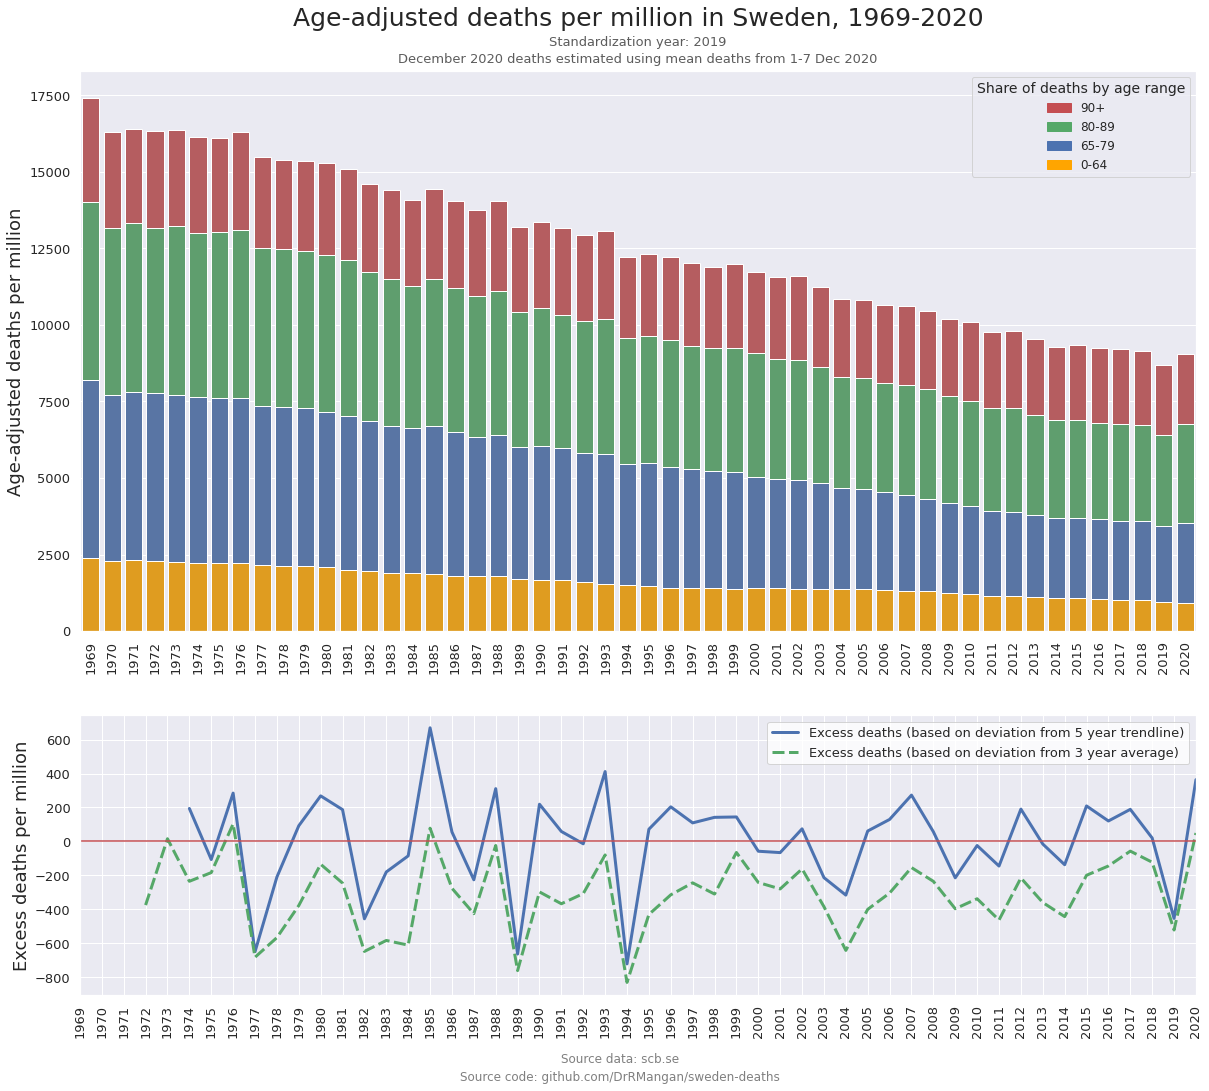

In [12]:
import matplotlib.patches as mpatches

sns.set_theme(style="darkgrid")

fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]}, figsize = (20,17))

axs[0] = sns.barplot(x=deaths_age_adj['total'].iloc[1:].index, y=(deaths_age_adj['0-64'].iloc[1:] + deaths_age_adj['65-79'].iloc[1:] + deaths_age_adj['80-89'].iloc[1:] + deaths_age_adj['90+'].iloc[1:])/10.23, color="r", ax=axs[0])
axs[0] = sns.barplot(x=deaths_age_adj['total'].iloc[1:].index, y=(deaths_age_adj['0-64'].iloc[1:] + deaths_age_adj['65-79'].iloc[1:] + deaths_age_adj['80-89'].iloc[1:])/10.23, color="g", ax=axs[0])
axs[0] = sns.barplot(x=deaths_age_adj['total'].iloc[1:].index, y=(deaths_age_adj['0-64'].iloc[1:] + deaths_age_adj['65-79'].iloc[1:])/10.23, color="b", ax=axs[0])
axs[0] = sns.barplot(x=deaths_age_adj['total'].iloc[1:].index, y=(deaths_age_adj['0-64'].iloc[1:])/10.23, color="orange", ax=axs[0])
red_patch = mpatches.Patch(color='r', label='90+')
green_patch = mpatches.Patch(color='g', label='80-89')
blue_patch = mpatches.Patch(color='b', label='65-79')
orange_patch = mpatches.Patch(color='orange', label='0-64')

axs[0].legend(handles=[red_patch, green_patch, blue_patch, orange_patch], title='Share of deaths by age range', title_fontsize=14, fontsize=12)

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_title('Age-adjusted deaths per million in Sweden, 1969-2020', fontsize=25, y=1.07)
axs[0].text(x=0.5, y=1.04, s='Standardization year: 2019', fontsize=13, alpha=0.75, ha='center', va='bottom', transform=axs[0].transAxes)
axs[0].text(x=0.5, y=1.01, s='December 2020 deaths estimated using mean deaths from 1-7 Dec 2020', fontsize=13, alpha=0.75, ha='center', va='bottom', transform=axs[0].transAxes)
axs[0].set_ylabel('Age-adjusted deaths per million', fontsize=18)
axs[0].tick_params(axis='both', labelsize=13)

sns.set_style("ticks")

axs[1] = sns.lineplot(data=deaths_age_adj[['excess1', 'excess2']], palette=['C0', 'C2'], ax=axs[1], linewidth=3)
plt.axhline(y=0, color='r', linestyle='-')
plt.xticks(rotation=90)
axs[1].set_xlim(left=1, right=52)
axs[1].set_ylabel('Excess deaths per million', fontsize=18)
axs[1].tick_params(axis='both', labelsize=13)

plt.legend(labels=['Excess deaths (based on deviation from 5 year trendline)', 'Excess deaths (based on deviation from 3 year average)'], fontsize=13)

plt.figtext(0.5, 0.07, "Source data: scb.se", color='gray', ha="center", fontsize=12)
plt.figtext(0.5, 0.055, "Source code: github.com/DrRMangan/sweden-deaths", color='gray', ha="center", fontsize=12)

fig.savefig('sweden.png')